In [82]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder



## **The dataset is shown below:**

In [147]:
data_df = pd.read_csv('../data/CreditPrediction.csv')
# removing duplicated datas
data_no_dup = data_df.drop_duplicates() 

In [148]:
def fix_missing_values(df):
    # Identify numerical and categorical columns
    num_cols = df.select_dtypes(exclude='object').columns
    cat_cols = df.select_dtypes(include='object').columns

    # Create transformers for numerical and categorical data
    num_transformer = IterativeImputer()
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ]
    )

    # Apply the transformations
    preprocessed_data = preprocessor.fit_transform(data_no_dup)

    # Convert the result back to a DataFrame (optional)
    preprocessed_df = pd.DataFrame(preprocessed_data)

    # Display the preprocessed DataFrame
    return preprocessed_df

In [138]:
X = data_no_dup.drop('Credit_Limit', axis=1)
y = data_no_dup['Credit_Limit']

X = fix_missing_values(X)


c:\Users\Kianoosh\anaconda3\envs\pytorch\Lib\site-packages\sklearn\impute\_base.py:597: UserWarning: Skipping features without any observed values: [13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Feature 0: 0.000000
Feature 1: 0.010283
Feature 2: 0.000000
Feature 3: 0.000000
Feature 4: 0.006195
Feature 5: 0.002232
Feature 6: 0.001140
Feature 7: 0.138877
Feature 8: 0.014241
Feature 9: 0.115873
Feature 10: 0.049153
Feature 11: 0.005825
Feature 12: 0.782106
Feature 13: 0.119148
Feature 14: 0.113249
Feature 15: 0.006925
Feature 16: 0.000000
Feature 17: 0.000000
Feature 18: 0.000482
Feature 19: 0.000000
Feature 20: 0.000000
Feature 21: 0.004931
Feature 22: 0.002604
Feature 23: 0.001795
Feature 24: 0.000000
Feature 25: 0.000000
Feature 26: 0.055697
Feature 27: 0.027210
Feature 28: 0.019845
Feature 29: 0.047694
Feature 30: 0.145378
Feature 31: 0.004862
Feature 32: 0.088856
Feature 33: 0.030745
Feature 34: 0.006917
Feature 35: 0.068704
11


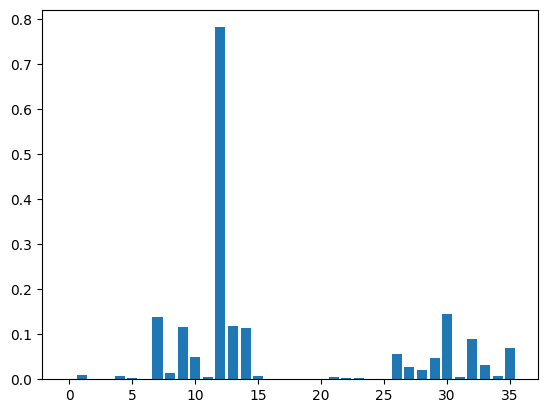

In [144]:
 
# feature selection
def select_features(X_train, y_train, X_test):
 # configure to select all features
 fs = SelectKBest(score_func=mutual_info_regression, k=26)
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 # transform test input data
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs
 
# load the dataset
# split into train and test sets
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
ignr_cnt = 0
for i in range(len(fs.scores_)):
 if (fs.scores_[i] < 0.0015):
  ignr_cnt +=1
 print('Feature %d: %f' % (i, fs.scores_[i]))
print(ignr_cnt)
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [2]:
4


4